# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Video: TBA

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# For data preprocess
import numpy as np
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# prevent from using gpu working on other's tasks in lab

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 52728  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    print("cuda_available")
    torch.cuda.manual_seed_all(myseed)

cuda_available


# **Some Utilities**

You do not need to modify this part.

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [4]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + [57, 75] + list(range(76, 76+4)) + list(range(40, 40+12))
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # self.data[:, 40:] = \
        #     (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, split_indices=None, mean=0, std=0, ae=None, device='cuda'):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode != 'test'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [6]:
class AE(nn.Module):
    def __init__(self, input_dim, feat_dim):
        super(AE, self).__init__()
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        act = nn.SELU
        # act = nn.ReLU
        self.feat_dim = feat_dim
        
        num_1 = 70
        num_2 = 30

        self.enc = nn.Sequential(
            nn.Linear(input_dim, num_1),
            act(),
            nn.Linear(num_1, num_2),
            act(),
            nn.Linear(num_2, feat_dim),
        )
        self.dec = nn.Sequential(
            act(),
            nn.Linear(feat_dim, num_2),
            act(),
            nn.Linear(num_2, num_1),
            act(),
            nn.Linear(num_1, input_dim),
        )
        self.net = nn.Sequential(self.enc, self.dec)
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        self.init_w()
    
    def init_w(self):
        for param in self.net.parameters():
            # biases zero
            if len(param.shape) == 1:
                nn.init.constant_(param, 0)
            # others using lecun-normal initialization
            else:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')


    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        return self.criterion(pred, target)
    
    def encode(self, x):
        return self.enc(x)


In [7]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, ae):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.seq2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(ae.feat_dim+40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

        self.enc = ae.enc
        self.net = nn.Sequential(
            self.enc,
            self.seq2
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        f = self.enc(x[..., 40:])
        i = torch.cat((x[..., :40], f), 1)
        return self.seq2(i).squeeze(1)

        # return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [8]:
def train(tr_set, dv_set, tt_set, model, ae, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs
    fix_ae = config['fix_ae']
    # Setup optimizer
    if fix_ae:
        optim_reg = getattr(torch.optim, config['optimizer'])(
            model.seq2.parameters(), **config['optim_hparas'])
    else:
        optim_reg = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])
    optim_ae = getattr(torch.optim, config['optimizer'])(
        ae.parameters(), **config['ae_optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'ae': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    pretrain = config['pretrain']
    aestop = config['aestop']
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        ae.train()
        tr_loss = []
        ae_loss = []
        tt_loss = []
        for x, y in tr_set:                     # iterate through the dataloader
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            
            # auto-enc
            if epoch <= aestop:
                optim_ae.zero_grad()
                xx = x[..., 40:]
                pred = ae(xx)
                mse_loss = ae.cal_loss(pred, xx)
                mse_loss.backward()
                optim_ae.step()
                ae_loss.append(mse_loss.detach().cpu().item())
            else:
                with torch.no_grad():
                    xx = x[..., 40:]
                    pred = ae(xx)
                    mse_loss = ae.cal_loss(pred, xx)
                ae_loss.append(mse_loss.detach().cpu().item())

            # regression
            if epoch >= pretrain:
            # if True:
                optim_reg.zero_grad()               # set gradient to zero
                pred = model(x)                     # forward pass (compute output)
                mse_loss = model.cal_loss(pred, y)  # compute loss
                mse_loss.backward()                 # compute gradient (backpropagation)
                optim_reg.step()                    # update model with optimizer
                tr_loss.append(mse_loss.detach().cpu().item())
            else:
                tr_loss.append(300)
        for x in tt_set:
            x = x.to(device)[..., 40:]
            if not fix_ae:
            # if epoch <= aestop:
                optim_ae.zero_grad()
                pred = ae(x)
                mse_loss = ae.cal_loss(pred, x)
                mse_loss.backward()
                optim_ae.step()
            else:
                with torch.no_grad():
                    pred = ae(x)
                    mse_loss = ae.cal_loss(pred, x)
            tt_loss.append(mse_loss.detach().cpu().item())


        loss_record['train'] += tr_loss
        loss_record['ae'] += ae_loss
        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, ae_loss = {:.4f}, tt_loss = {:.4f}, tr_loss = {:.4f}, dv_loss = {:.4f})'
                .format(epoch + 1, np.mean(ae_loss), np.mean(tt_loss), np.mean(tr_loss), min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            torch.save(ae.state_dict(), config['ae_save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # print('Saving model (epoch = {:4d}, tr_loss = {:.4f}, dv_loss = {:.4f})'
            #     .format(epoch + 1, mse_loss, dev_mse))
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [9]:
def ae_train(tr_sets, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    reg = config.get('reg')
    if reg:
    # if False:
        print("Not apply l2-reg on bias")
        weight_p, bias_p = [], []
        for name, p in model.named_parameters():
            if 'bias' in name:
                bias_p += [p]
            else:
                weight_p += [p]
        optimizer = getattr(torch.optim, config['optimizer'])([
            {'params' : weight_p, 'weight_decay' : config['reg']},
            {'params' : bias_p, 'weight_decay' : 0}
            ], **config['optim_hparas'])
    else:
        print("Apply l2-reg on bias")
        optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = []      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    save_count = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        tr_loss = []
        for s in tr_sets:
            for x in s:                     # iterate through the dataloader
                x = x[0][..., 40:]
                optimizer.zero_grad()               # set gradient to zero
                x = x.to(device)   # move data to device (cpu/cuda)
                
                pred = model(x)                     # forward pass (compute output)
                mse_loss = model.cal_loss(pred, x)  # compute loss
                mse_loss.backward()                 # compute gradient (backpropagation)
                optimizer.step()                    # update model with optimizer
                tr_loss.append(mse_loss.detach().cpu().item())
        
        loss_record += tr_loss

        print('Saving model (epoch = {:4d}, tr_loss = {:.4f})'
                .format(epoch + 1, np.mean(tr_loss)))

        epoch += 1
        

    print('Finished training after {} epochs'.format(epoch))
    return loss_record

## **Validation**

In [10]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [11]:
def ae_dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x = x.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, x)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss
    return total_loss

## **Testing**

In [12]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [13]:
def ae_test(tt_set, ae, device):
    ae.eval()
    err = []
    for x in tt_set:
        x = x.to(device)[..., 40:]
        with torch.no_grad():
            pred = ae(x)
            mse_loss = ae.cal_loss(pred, x)
            mse_loss = mse_loss.detach().cpu().item()
        err.append(mse_loss)
        print("err: {:.4f}".format(mse_loss))
    print(np.mean(err))


# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [14]:

device = get_device()                 # get the current available device ('cpu' or 'cuda')
# print(device)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
# target_only = True                   # TODO: Using 40 states & 2 tested_positive features
target_only = False

# TODO: How to tune these hyper-parameters to improve your model's performance?
ae_config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 135,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-5,                 # learning rate of SGD
        # 'momentum': 0.8,              # momentum for SGD
        'weight_decay': 1e-5,
    },
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/ae_model.pth'  # your model will be saved here
}

config = {
    'n_epochs': 10000,                # maximum number of epochs
    'batch_size': 135,               # mini-batch size for dataloader
    'feat_dim': 20,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-4,                 # learning rate of SGD
        # 'momentum': 0.8,              # momentum for SGD
        'weight_decay': 1e-2,
    },
    'fix_ae': False,
    'ae_optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-5,                 # learning rate of SGD
        # 'momentum': 0.3,              # momentum for SGD
        'weight_decay': 1e-3,
    },
    'pretrain': 0,
    'aestop': 1000,
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    'ae_save_path': 'models/ae_model.pth'  # your model will be saved here
}

# **Load data and model**

In [15]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [17]:
create_ae = lambda : AE(tr_set.dataset.dim-40, config['feat_dim']).to(device)

In [18]:
# ae = AE(tr_set.dataset.dim, config['feat_dim']).to(device)
ae = create_ae()
model = NeuralNet(tr_set.dataset.dim, ae).to(device)  # Construct model and move to device

In [57]:
print(np.sum([p.flatten().shape for p in model.parameters()]))
print(np.sum([p.flatten().shape for p in ae.parameters()]))

7127
12425


In [71]:
# AE
# ae = AE(dv_set.dataset[0][0].shape[0], 60).to(device)
_ = ae_train([tr_set, dv_set], ae, ae_config, device)

Saving model (epoch = 4567, tr_loss = 0.1833)
Saving model (epoch = 4568, tr_loss = 0.1832)
Saving model (epoch = 4569, tr_loss = 0.1832)
Saving model (epoch = 4570, tr_loss = 0.1832)
Saving model (epoch = 4571, tr_loss = 0.1832)
Saving model (epoch = 4572, tr_loss = 0.1831)
Saving model (epoch = 4573, tr_loss = 0.1832)
Saving model (epoch = 4574, tr_loss = 0.1829)
Saving model (epoch = 4575, tr_loss = 0.1830)
Saving model (epoch = 4576, tr_loss = 0.1829)
Saving model (epoch = 4577, tr_loss = 0.1829)
Saving model (epoch = 4578, tr_loss = 0.1829)
Saving model (epoch = 4579, tr_loss = 0.1828)
Saving model (epoch = 4580, tr_loss = 0.1827)
Saving model (epoch = 4581, tr_loss = 0.1827)
Saving model (epoch = 4582, tr_loss = 0.1826)
Saving model (epoch = 4583, tr_loss = 0.1827)
Saving model (epoch = 4584, tr_loss = 0.1826)
Saving model (epoch = 4585, tr_loss = 0.1823)
Saving model (epoch = 4586, tr_loss = 0.1823)
Saving model (epoch = 4587, tr_loss = 0.1824)
Saving model (epoch = 4588, tr_los

[969.4332275390625,
 953.3667602539062,
 963.5753173828125,
 957.6304931640625,
 961.166015625,
 961.8948974609375,
 957.173828125,
 956.8772583007812,
 958.1430053710938,
 967.6138305664062,
 962.451416015625,
 956.3955688476562,
 960.4403686523438,
 949.3460083007812,
 953.3322143554688,
 952.7872314453125,
 956.4413452148438,
 950.2208251953125,
 953.6275024414062,
 953.0460205078125,
 950.1307983398438,
 952.0824584960938,
 954.7013549804688,
 959.9443969726562,
 953.4217529296875,
 951.9844360351562,
 951.0736694335938,
 948.1134033203125,
 946.9901123046875,
 946.7302856445312,
 934.4735717773438,
 942.8558959960938,
 950.8539428710938,
 944.35693359375,
 932.0897827148438,
 952.714599609375,
 938.7844848632812,
 942.9588623046875,
 942.7852783203125,
 942.071044921875,
 940.1351318359375,
 942.3674926757812,
 935.0709838867188,
 949.5866088867188,
 938.0651245117188,
 933.8348999023438,
 943.1187744140625,
 936.37451171875,
 939.5879516601562,
 933.7474365234375,
 938.2386474609

In [37]:
for p in model.enc.parameters():
    print(p.requires_grad)
    p.requires_grad = False

False
False
False
False


In [72]:
_, model_loss_record = train(tr_set, dv_set, tt_set, model, ae, config, device)

= 5.8673, tt_loss = 6.5381, tr_loss = 1.5411, dv_loss = 1.4664)
Saving model (epoch =   54, ae_loss = 5.5150, tt_loss = 6.1389, tr_loss = 1.5114, dv_loss = 1.4057)
Saving model (epoch =   62, ae_loss = 4.2836, tt_loss = 4.7756, tr_loss = 1.4184, dv_loss = 1.3889)
Saving model (epoch =   64, ae_loss = 4.0502, tt_loss = 4.5051, tr_loss = 1.4078, dv_loss = 1.3765)
Saving model (epoch =   65, ae_loss = 3.9345, tt_loss = 4.3763, tr_loss = 1.4075, dv_loss = 1.3425)
Saving model (epoch =   66, ae_loss = 3.8147, tt_loss = 4.2549, tr_loss = 1.4096, dv_loss = 1.3045)
Saving model (epoch =   67, ae_loss = 3.7083, tt_loss = 4.1494, tr_loss = 1.3982, dv_loss = 1.2752)
Saving model (epoch =   74, ae_loss = 3.0840, tt_loss = 3.4728, tr_loss = 1.3787, dv_loss = 1.2630)
Saving model (epoch =   75, ae_loss = 2.9888, tt_loss = 3.3321, tr_loss = 1.4032, dv_loss = 1.2484)
Saving model (epoch =   76, ae_loss = 2.9141, tt_loss = 3.2719, tr_loss = 1.3644, dv_loss = 1.2343)
Saving model (epoch =   82, ae_loss 

7277908325,
   1.2134183049201965,
   1.1565412878990173,
   1.1591220498085022,
   1.1503956317901611,
   1.1680160164833069,
   1.1683529615402222,
   1.219775915145874,
   1.1580893993377686,
   1.1654012799263,
   1.161908209323883,
   1.1565817594528198,
   1.1445513367652893,
   1.1584385931491852,
   1.201051950454712,
   1.152254194021225,
   1.1704266369342804,
   1.2087026834487915,
   1.1367771625518799,
   1.1365850567817688,
   1.1508129835128784,
   1.1418454051017761,
   1.1563995480537415,
   1.1423433423042297,
   1.134347140789032,
   1.1365264058113098,
   1.128211498260498,
   1.2627192735671997,
   1.1339498162269592,
   1.1272773742675781,
   1.2552493810653687,
   1.1355313658714294,
   1.249148428440094,
   1.1257686018943787,
   1.1567411422729492,
   1.2284507751464844,
   1.126044750213623,
   1.180282175540924,
   1.118960440158844,
   1.1400628685951233,
   1.1551653146743774,
   1.1629112362861633,
   1.2054556012153625,
   1.1317315697669983,
   1.1219221

# **Start Training!**

In [73]:
plot_learning_curve(model_loss_record, title='deep model')

NameError: name 'model_loss_record' is not defined

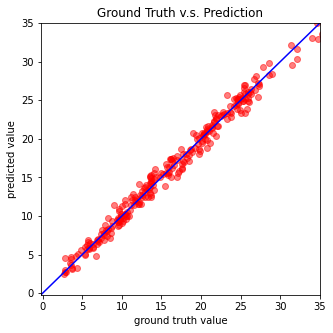

In [19]:
# del model
# del ae
# ae = AE(tr_set.dataset.dim, config['feat_dim']).to(device)
ae = create_ae()
ckpt = torch.load(config['ae_save_path'], map_location='cpu')  # Load your best model
ae.load_state_dict(ckpt)

model = NeuralNet(tr_set.dataset.dim, ae).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [20]:
ae_test(tt_set, ae, device)

err: 0.2558
err: 0.2368
err: 0.2414
err: 0.2320
err: 0.2179
err: 0.2336
err: 0.2330
0.23579423768179758


In [22]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# preds = test(ae_tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
